In [12]:
import math
import operator
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng
from tic_env import TictactoeEnv, OptimalPlayer

# 2. Q-learning

## 2.1 Learning from experts

In [13]:
def grid_to_string(grid):
    char_rep= {0:'-', 1: 'X',-1:'O'}
    return ''.join([char_rep[x] for x in grid.flatten()])

In [14]:
def action_to_key(action,  state):
    if type(action) is tuple:
        action = action[0]*3 + action[1]
    return (action, grid_to_string(state))

In [15]:
def get_state_best_Q(state, Q_vals, player_rnd):
    
    pot_actions = player_rnd.empty(state)
     # optimal choice wrt policy (eps-greedy)
    best_Q = -math.inf
    best_key = None

    for a in pot_actions:                    
        key = action_to_key(a, state)

        Q_a = Q_vals.get(key, 0)

        if (Q_a > best_Q):
            best_Q = Q_a
            best_key = key
    return best_key, best_Q

In [17]:
### Q-learning algorithm

# game constants
Turns = np.array(['X','O'])
max_game_length = 9
seed = 42
rng = default_rng(seed)
env = TictactoeEnv()
Q_vals = {}

# training constants
epoch = 20000
lr = 0.05
df = 0.99

# epsilon_greed = 0.1 #set in [0 ; 1[
epsilon_greed_max = 0.8
epsilon_greed_min = 0.1
n_star = 20000

# plot variables
avg_reward = []
avg_step = 50 
acc_reward = 0

for ep in range(0, epoch):
    # add mean reward to plot every avg_step epoch
    if ((ep+1)%avg_step==0):
        avg_reward.append(acc_reward/avg_step)
        acc_reward = 0
    
    # init Optimal player (epsilon 0.5) and random player, swap starting role every epoch
    player_opt = OptimalPlayer(epsilon=0.5, player=Turns[ep%2])
    player_rnd = OptimalPlayer(epsilon=1., player=Turns[(ep+1)%2])
    
    # update epsilon-greed
    epsilon_greed = max(epsilon_greed_min, epsilon_greed_max * (1-((ep+1)/n_star)) )
    
    pred_key, pred_rew  = None, None
    
    # game plays up to 9 times
    for j in range(max_game_length):
        
        # the optimal player plays if it its turn
        if env.current_player == player_opt.player:
            move = player_opt.act(env.grid)
        
        # the learner plays if it is their turn
        else:
            # update Q-val if this is not the first time playing
            if(j != 0 and j!=1):
                Q_v = Q_vals.get(pred_key, 0.0)
                Q_vals[pred_key] = Q_v + lr * (pred_rew + df * get_state_best_Q(env.grid, Q_vals, player_rnd)[1] - Q_v) 
            
            # epsilon chance the player plays randomly
            if(rng.uniform() <= epsilon_greed):
                move = player_rnd.act(env.grid)
            
            # otherwise plays according to the policy
            else:
                key, _ = get_state_best_Q(env.grid, Q_vals, player_rnd)
                move = key[0]
        
        # save current state values before next move is applied
        prev_grid = env.grid.copy()
        round_player = env.current_player
        grid, end, winner = env.step(move, print_grid=False)
        
        # if this is learner's turn, saves additional previous state info 
        if round_player == player_rnd.player:
            pred_key = action_to_key(move, prev_grid)
            pred_rew = env.reward(player_rnd.player)        
        
        # if the game ends, must update the Q-vals before starting a new game
        if end:
            if(round_player != player_rnd.player):
                Q_v = Q_vals.get(pred_key, 0.0)
                # Q_vals[pred_key] = Q_v + lr * (pred_rew - Q_v)   ==> pas checké que mon fix faisait du sens logiquement mais en gros dans la situation actuelle on prenait jamais en compte les moments ou le player perd
                Q_vals[pred_key] = Q_v + lr * (env.reward(player_rnd.player) - Q_v)
            else:
                key = action_to_key(move, prev_grid)
                Q_v = Q_vals.get(key, 0.0)
                Q_vals[key] = Q_v + lr * (env.reward(player_rnd.player) - Q_v)
            
            # reset new game
            acc_reward += env.reward(player_rnd.player)
            env.reset()
            break

In [ ]:
def function_sale(n_star):

    ### Q-learning algorithm

    # game constants
    Turns = np.array(['X','O'])
    max_game_length = 9
    seed = 42
    rng = default_rng(seed)
    env = TictactoeEnv()
    Q_vals = {}

    # training constants
    epoch = 20000
    lr = 0.05
    df = 0.99

    # epsilon_greed = 0.1 #set in [0 ; 1[
    epsilon_greed_max = 0.8
    epsilon_greed_min = 0.1

    # plot variables
    avg_reward = []
    avg_step = 50 
    acc_reward = 0

    for ep in range(0, epoch):
        # add mean reward to plot every avg_step epoch
        if ((ep+1)%avg_step==0):
            avg_reward.append(acc_reward/avg_step)
            acc_reward = 0

        # init Optimal player (epsilon 0.5) and random player, swap starting role every epoch
        player_opt = OptimalPlayer(epsilon=0.5, player=Turns[ep%2])
        player_rnd = OptimalPlayer(epsilon=1., player=Turns[(ep+1)%2])

        # update epsilon-greed
        epsilon_greed = max(epsilon_greed_min, epsilon_greed_max * (1-((ep+1)/n_star)) )

        pred_key, pred_rew  = None, None

        # game plays up to 9 times
        for j in range(max_game_length):

            # the optimal player plays if it its turn
            if env.current_player == player_opt.player:
                move = player_opt.act(env.grid)

            # the learner plays if it is their turn
            else:
                # update Q-val if this is not the first time playing
                if(j != 0 and j!=1):
                    Q_v = Q_vals.get(pred_key, 0.0)
                    Q_vals[pred_key] = Q_v + lr * (pred_rew + df * get_state_best_Q(env.grid, Q_vals, player_rnd)[1] - Q_v) 

                # epsilon chance the player plays randomly
                if(rng.uniform() <= epsilon_greed):
                    move = player_rnd.act(env.grid)

                # otherwise plays according to the policy
                else:
                    key, _ = get_state_best_Q(env.grid, Q_vals, player_rnd)
                    move = key[0]

            # save current state values before next move is applied
            prev_grid = env.grid.copy()
            round_player = env.current_player
            grid, end, winner = env.step(move, print_grid=False)

            # if this is learner's turn, saves additional previous state info 
            if round_player == player_rnd.player:
                pred_key = action_to_key(move, prev_grid)
                pred_rew = env.reward(player_rnd.player)        

            # if the game ends, must update the Q-vals before starting a new game
            if end:
                if(round_player != player_rnd.player):
                    Q_v = Q_vals.get(pred_key, 0.0)
                    # Q_vals[pred_key] = Q_v + lr * (pred_rew - Q_v)   ==> pas checké que mon fix faisait du sens logiquement mais en gros dans la situation actuelle on prenait jamais en compte les moments ou le player perd
                    Q_vals[pred_key] = Q_v + lr * (env.reward(player_rnd.player) - Q_v)
                else:
                    key = action_to_key(move, prev_grid)
                    Q_v = Q_vals.get(key, 0.0)
                    Q_vals[key] = Q_v + lr * (env.reward(player_rnd.player) - Q_v)

                # reset new game
                acc_reward += env.reward(player_rnd.player)
                env.reset()
                break    
    

In [ ]:
n_star_vals = [1, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000]
plots = []

for ns in n_star_vals:
    avg_reward = function_sale(ns)
    plots.append(avg_reward)

In [18]:
Q_vals

{(4, '------X--'): 0.10886501433297907,
 (5, '--X-O-X--'): 0.005939679776903635,
 (0, '--XXOOX--'): 0.014050931257972707,
 (8, 'OXXXOOX--'): 0.3365795687109375,
 (5, '---------'): 0.0918832846193329,
 (0, '----OX---'): 0.011230638566944905,
 (6, 'X-O-OX---'): 0.1579104506982737,
 (1, 'X-OOOXX--'): 0.0,
 (7, 'XXOOOXX-O'): 0.0,
 (3, '-------X-'): 0.00014876110894395677,
 (1, '--XO---X-'): 0.0,
 (4, 'XOXO---X-'): 0.0071775,
 (6, 'XOXOOX-X-'): -0.2262190625,
 (0, '---------'): 0.5527601833569956,
 (3, 'X---O----'): 0.2596648697679611,
 (6, 'X--XO---O'): 0.5598733313482342,
 (1, '--X-O-X--'): 0.4782572718643058,
 (0, '-OX-O-XX-'): -0.37108549448290673,
 (6, '---------'): 0.10747302478829059,
 (5, 'O-----X--'): 0.0,
 (7, 'O-O--XX--'): -0.13549375,
 (1, 'X--------'): -0.008906573389679108,
 (2, 'XO--X----'): -0.08618904687500001,
 (1, 'X----O---'): 0.08244482677396148,
 (6, 'XXO--O---'): -0.18549375,
 (3, 'XXO--OXO-'): 0.5367087698402466,
 (6, '---X-----'): 0.00010206336390056151,
 (0, '---XX

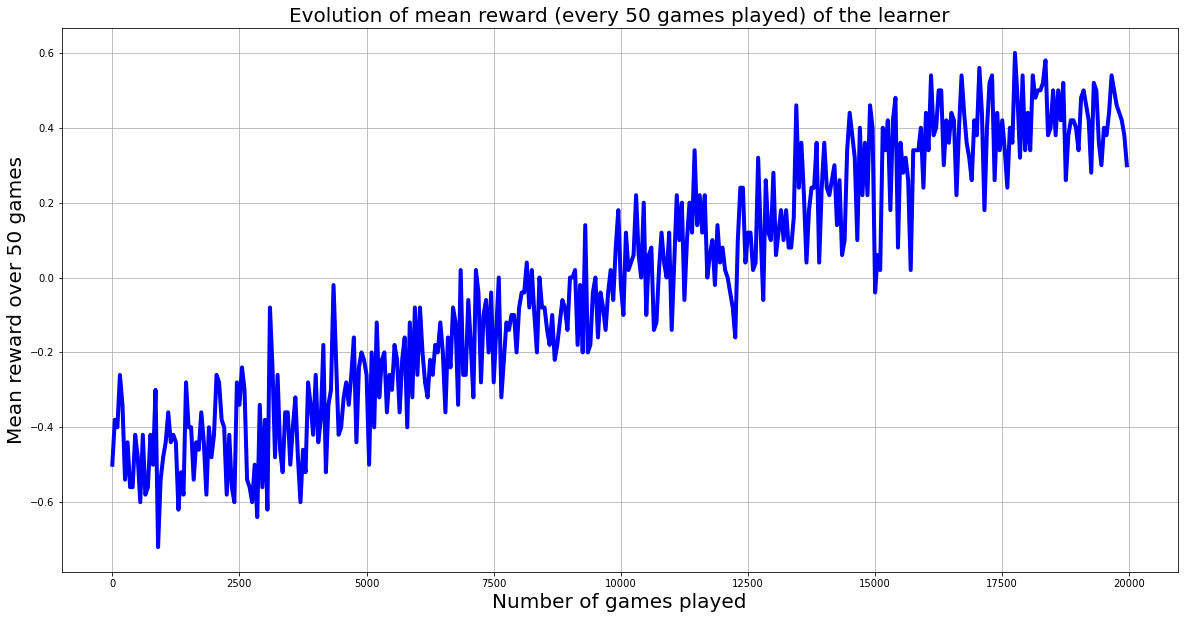

In [19]:
#View evolving mean reward of the learner
plt.figure(figsize=(20, 10))
plt.plot(range(0, 20000, 50), avg_reward, 'b', lw=4)
plt.xlabel('Number of games played', fontsize= 20)
plt.ylabel('Mean reward over {} games'.format(avg_step), fontsize = 20)
plt.title('Evolution of mean reward (every {} games played) of the learner'.format(avg_step), fontsize = 20)
plt.grid()
plt.show()

In [20]:
np.mean(np.array(avg_reward))

-0.009649999999999982

In [21]:
np.mean(avg_reward[-50:-1])

0.4293877551020408

In [10]:
neg_Q = filter(lambda x : x<0 , Q_vals.values())
nb_neg = len([x for x in neg_Q])

print(nb_neg)

1680


In [11]:
print(len(Q_vals.values()) - nb_neg)

1829
